<a href="https://colab.research.google.com/github/Hanzlah10/CFA/blob/main/cfa_with_xai_enhanced_version_with_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explaining using SHAP:


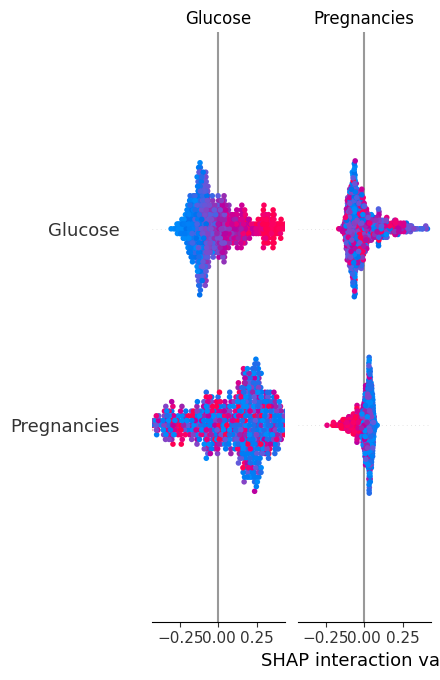

1. Analyzing Original Data Distribution


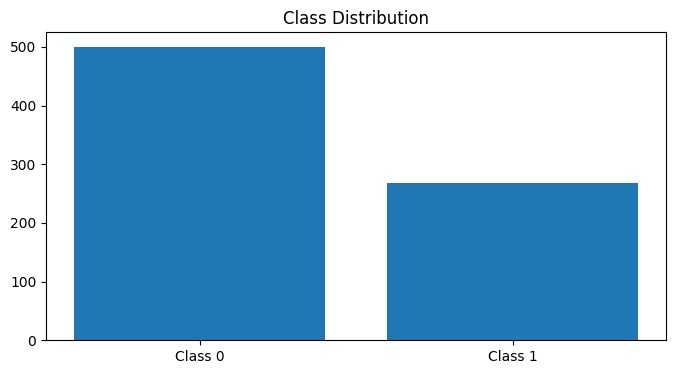

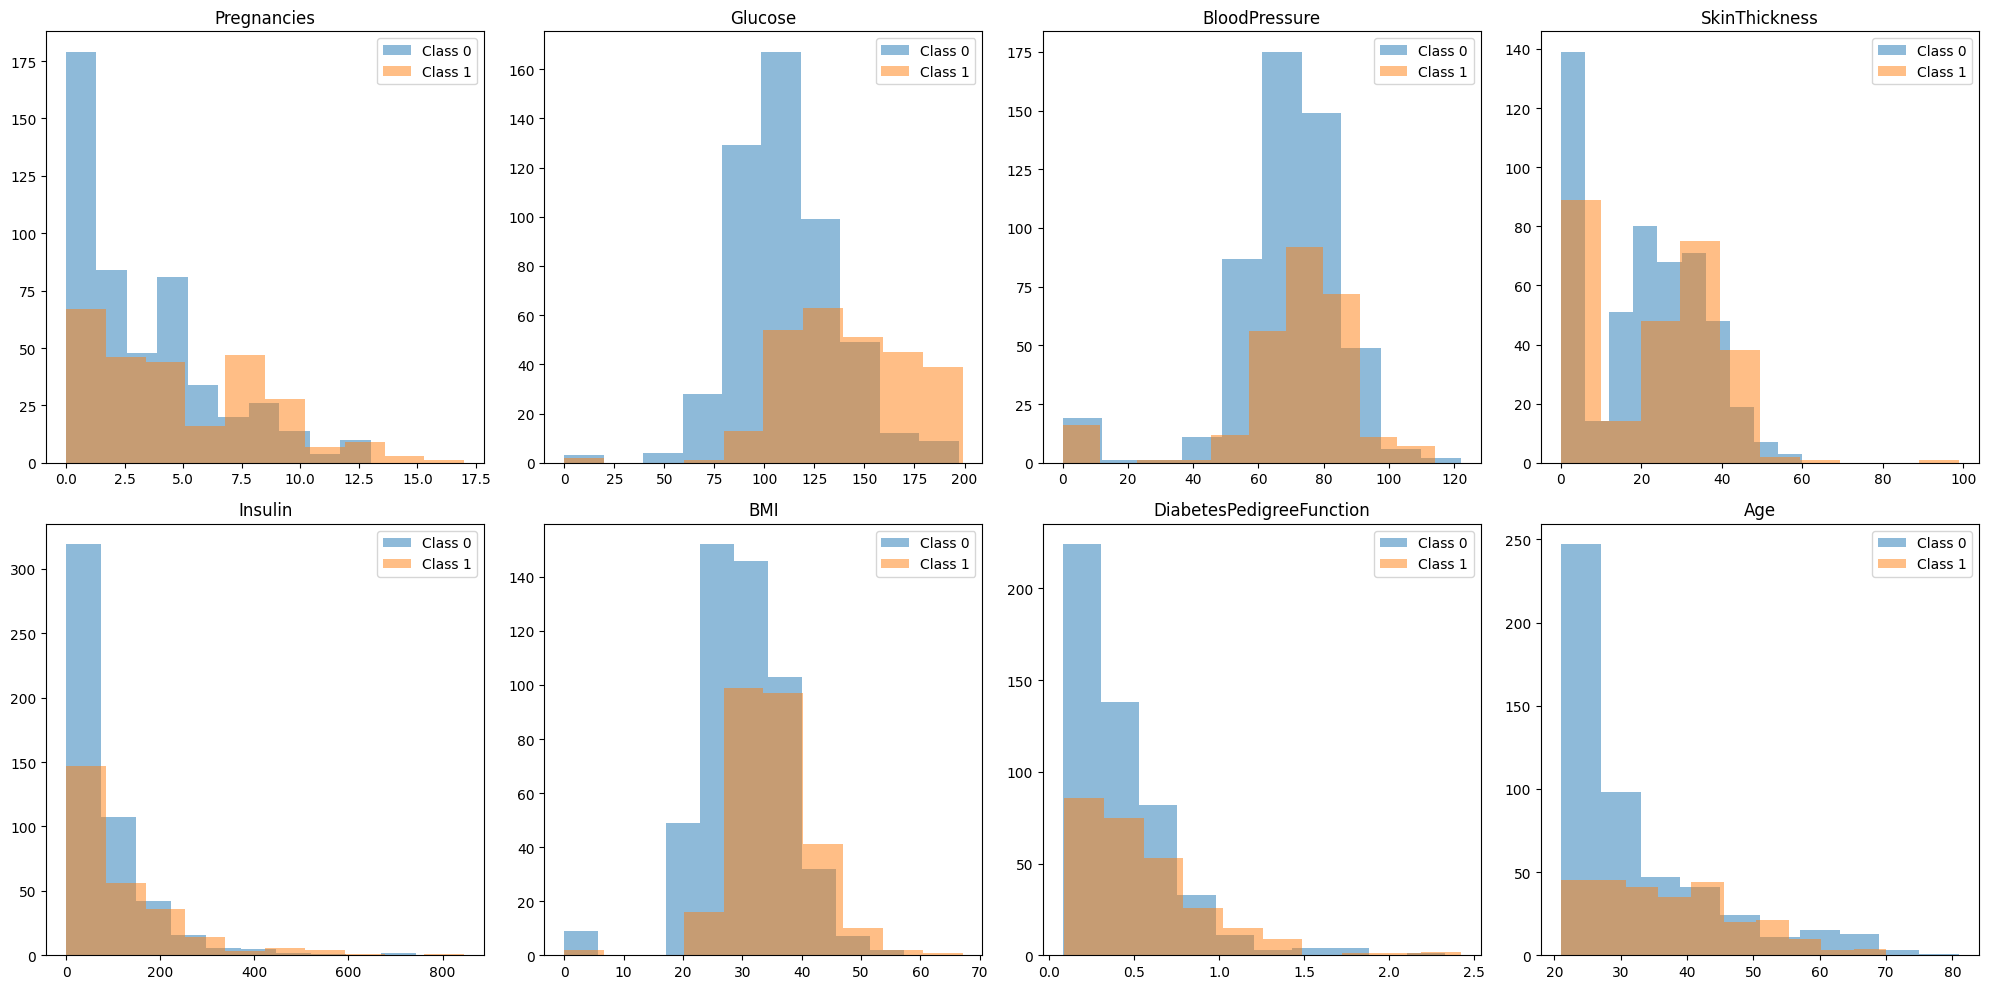


2. Selecting Important Features


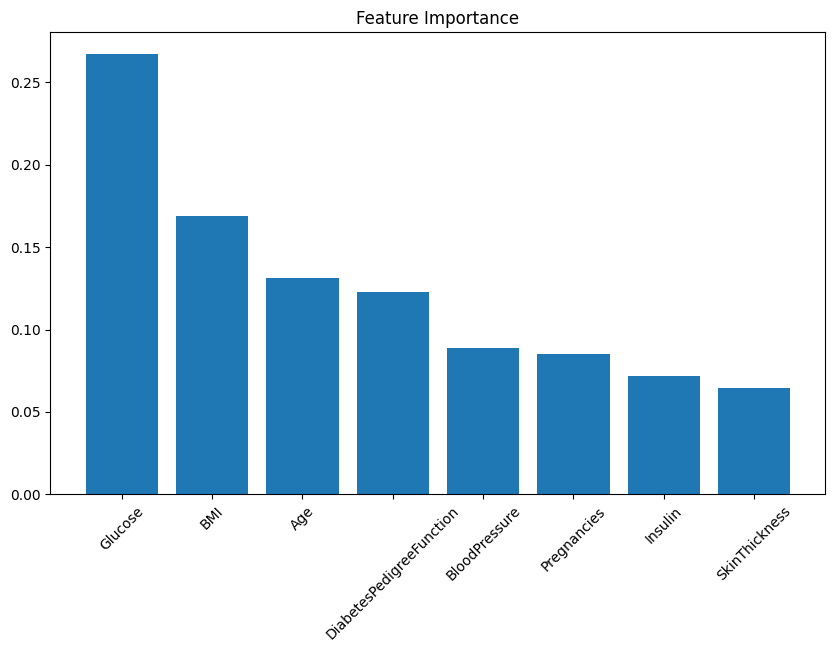


Feature Importance Scores:
Glucose: 0.2671
BMI: 0.1688
Age: 0.1316
DiabetesPedigreeFunction: 0.1227
BloodPressure: 0.0887
Pregnancies: 0.0850
Insulin: 0.0715
SkinThickness: 0.0646

Tolerance levels for important features:
Glucose: 6.3904
BMI: 1.5758
Age: 2.3505
DiabetesPedigreeFunction: 0.0662
BloodPressure: 3.8686
Pregnancies: 0.6735
Insulin: 23.0338
SkinThickness: 3.1884

Class distribution:
Majority class: 500
Minority class: 268

Generated 135 synthetic instances

3. Visualizing Results
Principal Component 1:
  SkinThickness: 0.4654
  BMI: 0.4533
  Insulin: 0.4491
  Glucose: 0.3787
  BloodPressure: 0.3436
  DiabetesPedigreeFunction: 0.2916
  Age: 0.1528
  Pregnancies: 0.0799
Principal Component 2:
  Age: 0.6349
  Pregnancies: 0.5947
  SkinThickness: -0.3018
  BloodPressure: 0.2227
  Glucose: 0.2089
  Insulin: -0.1993
  DiabetesPedigreeFunction: -0.1103
  BMI: -0.0839


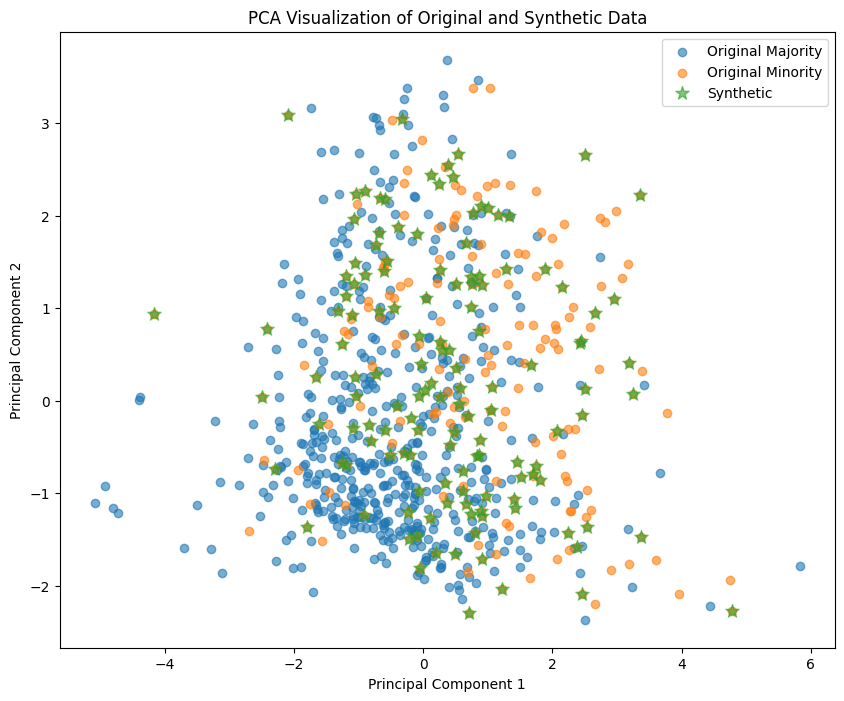


Final Results:
---------------------------------------------------------------------
Original dataset shape: (768, 8)
Augmented dataset shape: (903, 8)
Number of synthetic instances: 135.0


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def analyze_data_distribution(X, y, feature_names):
    """Show class distribution and feature importance"""
    # Class distribution
    plt.figure(figsize=(8, 4))
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(['Class ' + str(i) for i in unique], counts)
    plt.title('Class Distribution')
    plt.show()

    # Feature distributions
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    for i, (ax, name) in enumerate(zip(axes.ravel(), feature_names)):
        for label in [0, 1]:
            ax.hist(X[y == label, i], alpha=0.5, label=f'Class {label}')
        ax.set_title(name)
        ax.legend()
    plt.tight_layout()
    plt.show()

def get_important_features(X, y, feature_names):
    """Get feature importance using Random Forest"""
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Plot feature importance
    importance = rf.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance')
    plt.bar(range(X.shape[1]), importance[indices])
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
    plt.show()

    # Print importance scores
    print("\nFeature Importance Scores:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importance[idx]:.4f}")

    return indices[importance[indices] > 0.05]

def visualize_results(X_original, X_synthetic, y_original, feature_names):
    """Visualize original and synthetic data using PCA"""
    # Combine all data
    X_combined = np.vstack([X_original, X_synthetic])

    # Apply PCA
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaler.fit_transform(X_combined))

    # Split back into original and synthetic
    X_pca_orig = X_pca[:len(X_original)]
    X_pca_synt = X_pca[len(X_original):]

    # Print feature contributions for the first two principal components
    for i, component in enumerate(pca.components_[:2], start=1):
        sorted_indices = np.argsort(np.abs(component))[::-1]
        sorted_features = [(feature_names[idx], component[idx]) for idx in sorted_indices]
        print(f"Principal Component {i}:")
        for feature, contribution in sorted_features:
            print(f"  {feature}: {contribution:.4f}")

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca_orig[y_original == 0, 0], X_pca_orig[y_original == 0, 1],
                label='Original Majority', alpha=0.6)
    plt.scatter(X_pca_orig[y_original == 1, 0], X_pca_orig[y_original == 1, 1],
                label='Original Minority', alpha=0.6)
    plt.scatter(X_pca_synt[:, 0], X_pca_synt[:, 1],
                label='Synthetic', marker='*', s=100, alpha=0.6)
    plt.legend()
    plt.title('PCA Visualization of Original and Synthetic Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


def generate_counterfactuals(X, y, feature_names, fd=2, tol=0.2):
    """Main CFA function"""
    print("1. Analyzing Original Data Distribution")
    analyze_data_distribution(X, y, feature_names)

    print("\n2. Selecting Important Features")
    important_features = get_important_features(X, y, feature_names)
    X_important = X[:, important_features]

    # Calculate tolerance
    tolerance = tol * np.std(X_important, axis=0)
    print("\nTolerance levels for important features:")
    for i, feat_idx in enumerate(important_features):
        print(f"{feature_names[feat_idx]}: {tolerance[i]:.4f}")

    # Separate classes
    majority_mask = y == 0
    majority_data = X_important[majority_mask]
    minority_data = X_important[~majority_mask]

    print(f"\nClass distribution:")
    print(f"Majority class: {len(majority_data)}")
    print(f"Minority class: {len(minority_data)}")

    # Generate synthetic instances
    synthetic_instances = []
    used_indices = []

    # Find pairs using nearest neighbors
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(majority_data)

    for min_instance in minority_data:
        dist, maj_idx = nn.kneighbors([min_instance])
        maj_idx = maj_idx[0][0]

        if maj_idx not in used_indices:
            diff = np.abs(min_instance - majority_data[maj_idx])
            if np.sum(diff <= tolerance) >= fd:
                synthetic = majority_data[maj_idx] + (min_instance - majority_data[maj_idx])
                synthetic_instances.append(synthetic)
                used_indices.append(maj_idx)

    if not synthetic_instances:
        print("\nNo synthetic instances generated. Try adjusting parameters.")
        return X, y, None

    synthetic_instances = np.array(synthetic_instances)

    # Create full synthetic instances
    majority_indices = np.where(majority_mask)[0]
    full_synthetic = np.zeros((len(synthetic_instances), X.shape[1]))
    for i, maj_idx in enumerate(used_indices):
        full_synthetic[i] = X[majority_indices[maj_idx]]
        full_synthetic[i, important_features] = synthetic_instances[i]

    print(f"\nGenerated {len(synthetic_instances)} synthetic instances")

    # Visualize results
    print("\n3. Visualizing Results")
    visualize_results(X, full_synthetic, y, feature_names)  # Pass feature_names here

    # Return augmented dataset
    X_augmented = np.vstack([X, full_synthetic])
    y_augmented = np.concatenate([y, np.ones(len(full_synthetic))])
    synthetic_labels = np.concatenate([np.zeros(len(X)), np.ones(len(full_synthetic))])

    return X_augmented, y_augmented, synthetic_labels

def explain_with_shap(X, model, feature_names):
    """Use SHAP to explain model predictions"""
    # Use TreeExplainer for RandomForestClassifier
    explainer = shap.TreeExplainer(model)

    # Get SHAP values for each class
    shap_values = explainer.shap_values(X)

    # Check if it's binary classification or multi-class
    if isinstance(shap_values, list):  # binary or multi-class classification
        # For binary classification (only two classes, index 0 and 1)
        shap_values_class_1 = shap_values[1]  # Class 1 (positive class)
    else:  # In case it's a regression task or single-class output
        shap_values_class_1 = shap_values

    # Summary plot for class 1 (positive class) or selected class
    # Ensure feature_names is a NumPy array
    shap.summary_plot(shap_values_class_1, X, feature_names=np.array(feature_names))

    # Visualizing SHAP values for a random instance (first instance)
    shap.initjs()
    shap.force_plot(shap_values_class_1[0], X[0], feature_names=feature_names)

def run_example_with_shap():
    # Load data
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'
    columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
              'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

    data = pd.read_csv(url, names=columns)
    X = data.drop('Outcome', axis=1).values
    y = data['Outcome'].values
    feature_names = list(data.drop('Outcome', axis=1).columns)

    # Fit Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Explain using SHAP
    print("Explaining using SHAP:")
    explain_with_shap(X, rf, feature_names)

    # Run CFA (Counterfactual Augmentation)
    X_augmented, y_augmented, synthetic_labels = generate_counterfactuals(
        X, y, feature_names, fd=2, tol=0.2
    )

    print("\nFinal Results:")
    print("-" * 69)
    print(f"Original dataset shape: {X.shape}")
    print(f"Augmented dataset shape: {X_augmented.shape}")
    print(f"Number of synthetic instances: {np.sum(synthetic_labels)}")

# Now you can run the example with SHAP explanations
run_example_with_shap()




1. PC1 is a new axis that combines features like SkinThickness, BMI, and Insulin, capturing the most variance.
2. PC2 is another new axis that combines features like Age and Pregnancies, capturing the remaining variance.
When plotting these projections, you're visualizing the data in a reduced dimension where the new axes(PC1 and PC2) explain the most important variations in the original features.